In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import loompy
import matplotlib as mpl
import harmonypy as hm 
import scirpy as ir
from matplotlib import pyplot as plt, cm as mpl_cm
from cycler import cycler
import celltypist
from celltypist import models

In [505]:
adata=sc.read_h5ad("./Bcell.h5ad")
adata

AnnData object with n_obs × n_vars = 28000 × 16547
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cellid', 'dataid', 'patient', 'site', 'type', 'cancer', 'treatment', 'celltype_raw_l1', 'celltype_raw_l2', 'nCount_SCT', 'nFeature_SCT', 'meta.cluster', 'celltype', 'percent.mt', 'DIG.Score1', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.1', 'seurat_clusters', 'RNA_snn_res.1.5', 'celltypeNew', 'celltypeN', 'RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.0.5', 'RNA_snn_res.2', 'B_signature', 'celltype_l1', 'BCR', 'barcode', 'id', 'celltype_l2', 'celltype_l3'
    var: '_index', 'features'

In [428]:
adata.obs['celltype_l3'].unique()

array(['B_01_TCL1A_naïveB', 'B_c03_HSP_B', 'B_c06_NR4A2_ACB2',
       'B_c08_ITGB1_SwBm', 'B_c09_DUSP4_AtM', 'B_c05_EGR1_ACB1',
       'B_c07_CCR7_ACB3', 'B_02_IFIT3_B', 'B_14_MZB1_rASC',
       'B_10_PSME2_PreGC', 'B_13_STMN1_PB', 'B_12_LMO2_LZGC',
       'B_11_CXCR4_DZGC', 'B_c04_MT1X_B'], dtype=object)

In [429]:
adata.var=adata.var.rename(columns={'_index': 'feature'})

In [430]:
adata.var.index=adata.var['feature']

In [431]:
adata.X.expm1().sum(axis = 1)

matrix([[9.63666567e+052],
        [8.65934005e+016],
        [1.71997426e+061],
        ...,
        [1.60948707e+048],
        [3.24418245e+125],
        [4.00363920e+121]])

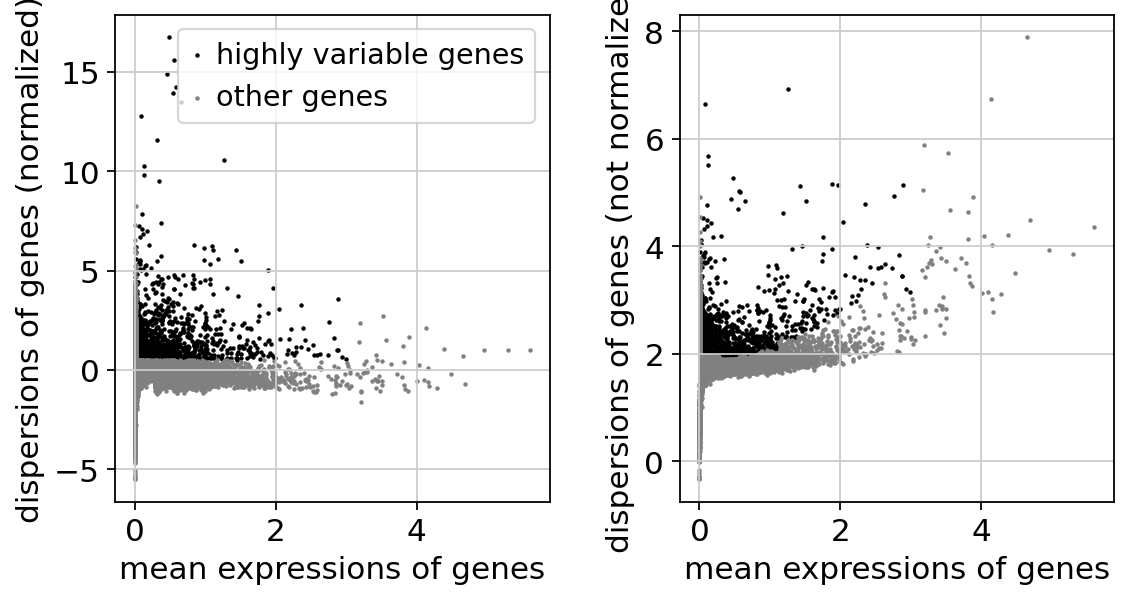

In [432]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [433]:
adata.X.expm1().sum(axis = 1)

matrix([[10000.],
        [10000.],
        [10000.],
        ...,
        [10000.],
        [10000.],
        [10000.]])

In [489]:
#new_model = celltypist.train(adata[:, adata.var.DEGs], labels = 'annotation', check_expression = False, feature_selection = True)
new_model = celltypist.train(adata, labels = 'celltype_l3', feature_selection = True,
                            n_jobs=10,top_genes=100)

🍳 Preparing data before training
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 721 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
✅ Model training done!


In [284]:
new_model.write('./celltypist/Bcell_feature_selection.pkl')

In [490]:
prediction_self = celltypist.annotate(adata, model = new_model, majority_voting = True)

🔬 Input data has 28000 cells and 16547 genes
🔗 Matching reference genes in the model
🧬 721 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


In [491]:
adata = prediction_self.to_adata()

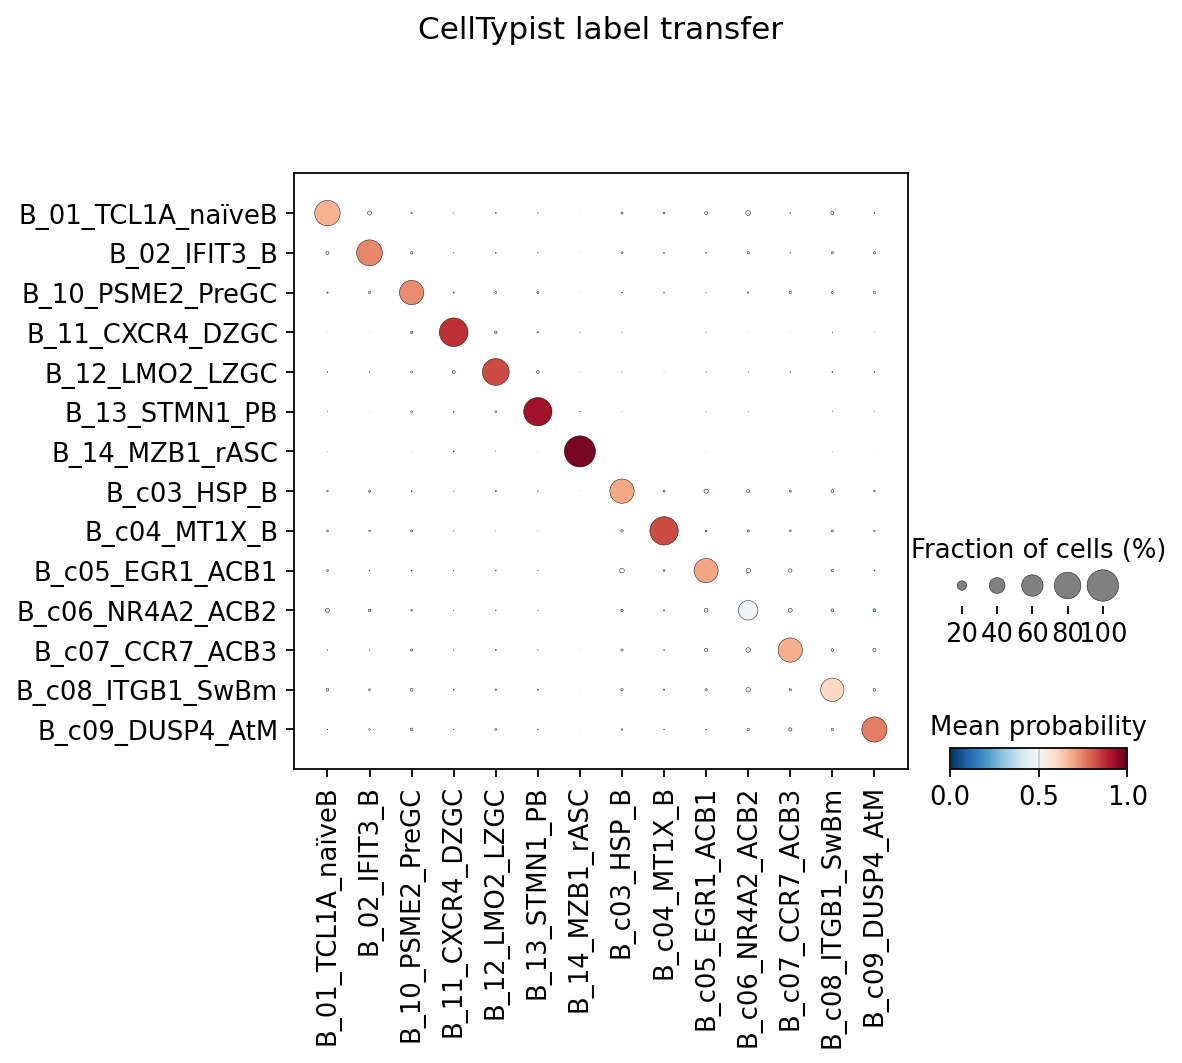

In [492]:
celltypist.dotplot(prediction_self, use_as_reference = 'celltype_l3', 
                   use_as_prediction = 'predicted_labels',
                  save="check.pdf")

# Check

In [493]:
new_model.cell_types

array(['B_01_TCL1A_naïveB', 'B_02_IFIT3_B', 'B_10_PSME2_PreGC',
       'B_11_CXCR4_DZGC', 'B_12_LMO2_LZGC', 'B_13_STMN1_PB',
       'B_14_MZB1_rASC', 'B_c03_HSP_B', 'B_c04_MT1X_B', 'B_c05_EGR1_ACB1',
       'B_c06_NR4A2_ACB2', 'B_c07_CCR7_ACB3', 'B_c08_ITGB1_SwBm',
       'B_c09_DUSP4_AtM'], dtype=object)

In [494]:
weights = new_model.classifier.coef_
weights.shape

(14, 721)

In [496]:
Naive_cell_weights = weights[new_model.cell_types == 'B_01_TCL1A_naïveB']
top_3_genes = new_model.features[Naive_cell_weights.argpartition(-20, axis = None)[-20:]]
top_3_genes

array(['RERE', 'FOS', 'SELK', 'MKI67', 'HLA-DQB1', 'CD74', 'TCEB1',
       'TXNDC5', 'HLA-DRB1', 'SEP15', 'BIRC5', 'RACK1', 'EEF1A1',
       'GNB2L1', 'MTRNR2L12', 'C17orf89', 'TCL1A', 'ATP5D', 'YBX3',
       'JUND'], dtype=object)

# Prediction 

In [301]:
new_model

CellTypist model with 14 cell types and 1937 features
    date: 2023-03-15 16:55:11.848798
    cell types: B_01_TCL1A_naïveB, B_02_IFIT3_B, ..., B_c09_DUSP4_AtM
    features: ISG15, AGRN, ..., AL135905.2

In [302]:
new_model.features

array(['ISG15', 'AGRN', 'TNFRSF18', ..., 'NIBAN3', 'SEPTIN6',
       'AL135905.2'], dtype=object)

In [497]:
adata_pre=sc.read_h5ad('./celltypist/Bcell_essay.h5ad')

In [502]:
predictions = celltypist.annotate(adata_pre, model = new_model)
#predictions = celltypist.annotate(adata_sub, model = new_model)

🔬 Input data has 37597 cells and 16997 genes
🔗 Matching reference genes in the model
🧬 656 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [503]:
adata_pre = predictions.to_adata()

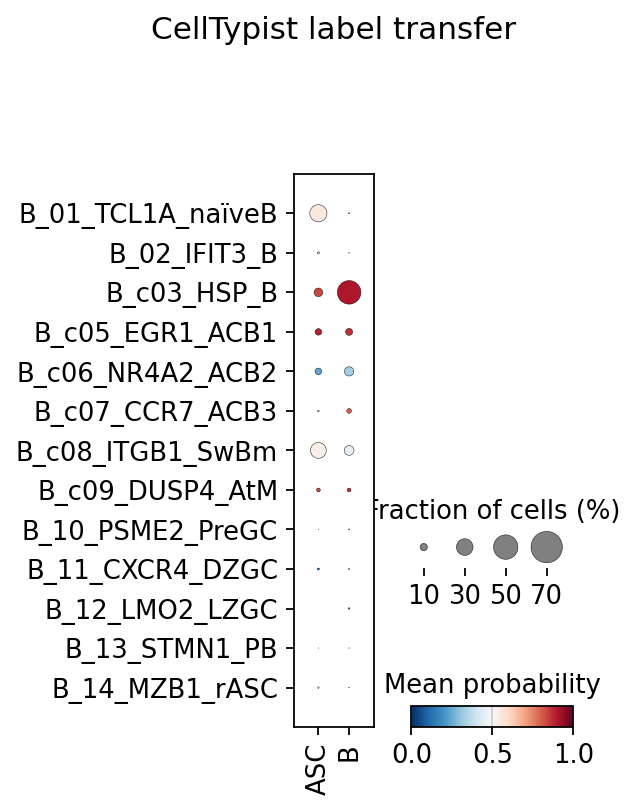

In [99]:
celltypist.dotplot(predictions, use_as_reference = 'celltype_l1',
                   prediction_order=['B_01_TCL1A_naïveB',
                                     'B_02_IFIT3_B',
                                     'B_c03_HSP_B',
                                     'B_c05_EGR1_ACB1',
                                     'B_c06_NR4A2_ACB2',
                                     'B_c07_CCR7_ACB3',
                                     'B_c08_ITGB1_SwBm',
                                     'B_c09_DUSP4_AtM',
                                     'B_10_PSME2_PreGC',
                                     'B_11_CXCR4_DZGC', 
                                     'B_12_LMO2_LZGC',
                                     'B_13_STMN1_PB',
                                     'B_14_MZB1_rASC' ],
                   use_as_prediction = 'predicted_labels', dot_max=0.7,
                  save="prediction_OA044.pdf")

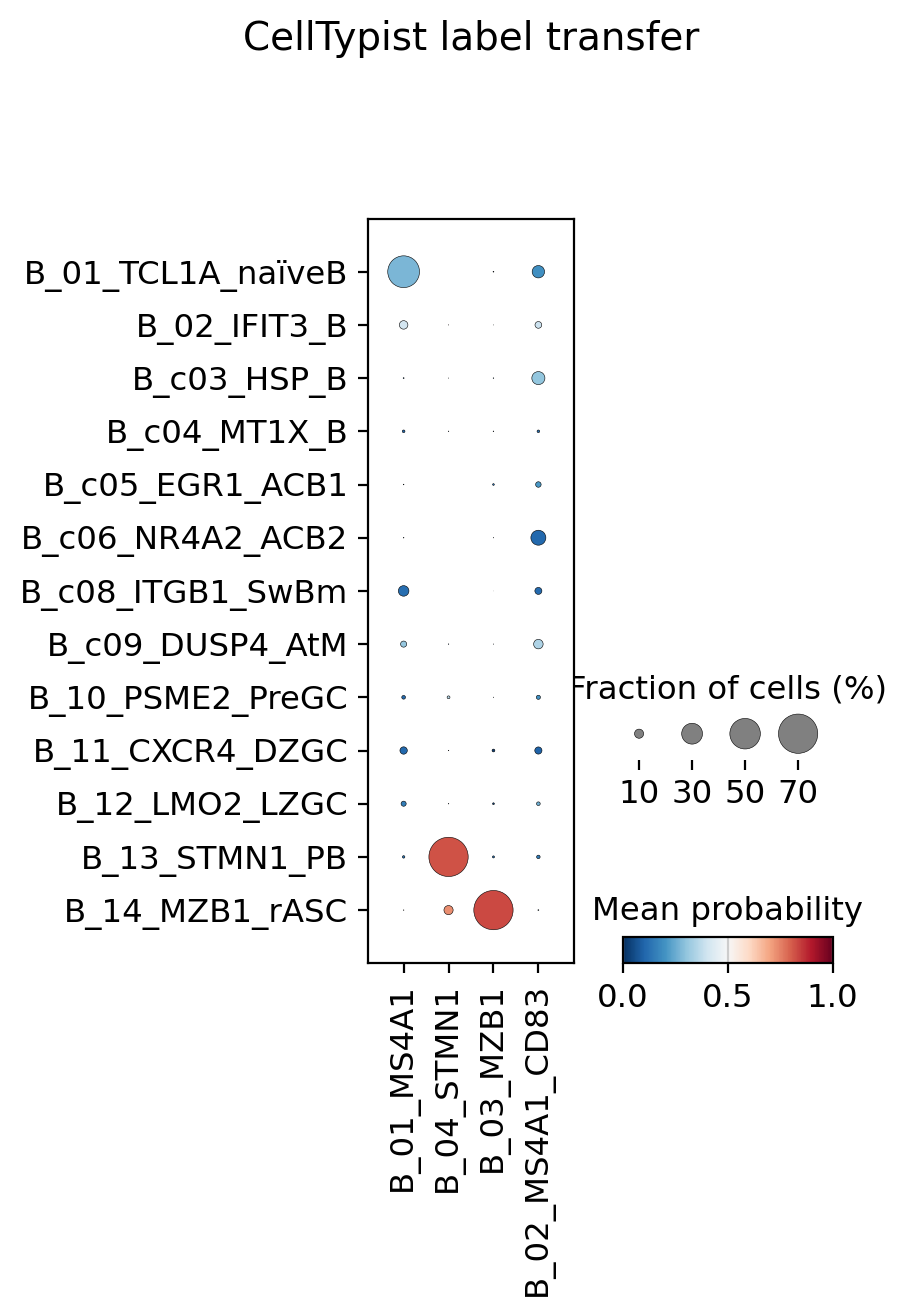

In [504]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
celltypist.dotplot(predictions, use_as_reference = 'clusters',
                   prediction_order=['B_01_TCL1A_naïveB',
                                     'B_02_IFIT3_B',
                                     'B_c03_HSP_B',
                                     'B_c04_MT1X_B',
                                     'B_c05_EGR1_ACB1',
                                     'B_c06_NR4A2_ACB2',
                                     'B_c08_ITGB1_SwBm',
                                     'B_c09_DUSP4_AtM',
                                     'B_10_PSME2_PreGC',
                                     'B_11_CXCR4_DZGC', 
                                     'B_12_LMO2_LZGC',
                                     'B_13_STMN1_PB',
                                     'B_14_MZB1_rASC' ],
                   use_as_prediction = 'predicted_labels', dot_max=0.7)